In [56]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import auc, multilabel_confusion_matrix,ConfusionMatrixDisplay,confusion_matrix,roc_curve
from pandas.tseries.holiday import USFederalHolidayCalendar

from Model import Model

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [57]:
#load csv into dataframes
crime_data = "San_Francisco.csv"
df = pd.read_csv(crime_data)

In [58]:
# Preprocess data (you'll need to adjust this to match your actual data)
df['Date_Time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Year'] = df['Date_Time'].dt.year
df['Month'] = df['Date_Time'].dt.month
df['Day'] = df['Date_Time'].dt.day
df['Time_minutes'] = df['Date_Time'].dt.hour * 60 + df['Date_Time'].dt.minute

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df['Date'].min(), end=df['Date'].max())
df['IsHoliday'] = df['Date'].isin(holidays)

Take a look at the data

In [59]:
df

,Unnamed: 0,Date,Time,Day_of_Week,Part_of_Day,Category,Latitude,Longitude,Date_Time,Year,Month,Day,Time_minutes,IsHoliday
0,0,2004-11-22,17:50:00,Monday,evening,ROBBERY,37.708311,-122.420084,2004-11-22 17:50:00,2004,11,22,1070,False
1,1,2010-11-21,17:00:00,Sunday,evening,ASSAULT,37.770913,-122.410541,2010-11-21 17:00:00,2010,11,21,1020,False
2,2,2013-04-02,15:50:00,Tuesday,afternoon,ASSAULT,37.745158,-122.470366,2013-04-02 15:50:00,2013,4,2,950,False
3,3,2017-08-06,18:15:00,Sunday,evening,ASSAULT,37.775421,-122.403405,2017-08-06 18:15:00,2017,8,6,1095,False
4,4,2016-03-03,19:30:00,Thursday,evening,VEHICLE THEFT,37.707968,-122.463545,2016-03-03 19:30:00,2016,3,3,1170,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787077,787077,2023-03-06,16:41:00,Monday,afternoon,LARCENY THEFT,37.805497,-122.422007,2023-03-06 16:41:00,2023,3,6,1001,False
787078,787078,2023-03-22,13:30:00,Wednesday,afternoon,ROBBERY,37.753004,-122.406336,2023-03-22 13:30:00,2023,3,22,810,False
787079,787079,2023-03-22,00:13:00,Wednesday,night,LARCENY THEFT,37.788995,-122.440624,2023-03-22 00:13:00,2023,3,22,13,False
787080,787080,2023-03-22,15:28:00,Wednesday,afternoon,LARCENY THEFT,37.790565,-122.405574,2023-03-22 15:28:00,2023,3,22,928,False


In [60]:
df['Category'].value_counts()

ASSAULT                210410
LARCENY THEFT          198155
BURGLARY               130802
VEHICLE THEFT          126213
ROBBERY                 70305
MOTOR VEHICLE THEFT     36222
STOLEN PROPERTY         14975
Name: Category, dtype: int64

In [61]:
df['IsHoliday'].value_counts()

False    787082
Name: IsHoliday, dtype: int64

In [62]:
# get column names
df.columns

Index(['Unnamed: 0', 'Date', 'Time', 'Day_of_Week', 'Part_of_Day', 'Category',
       'Latitude', 'Longitude', 'Date_Time', 'Year', 'Month', 'Day',
       'Time_minutes', 'IsHoliday'],
      dtype='object')

In [63]:
# Convert the Date and Time columns to datetime objects
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Extract the hour of the day from the DateTime column
df['Hour'] = df['DateTime'].dt.hour

[Text(0, 0, 'ASSAULT'),
 Text(1, 0, 'LARCENY THEFT'),
 Text(2, 0, 'BURGLARY'),
 Text(3, 0, 'VEHICLE THEFT'),
 Text(4, 0, 'ROBBERY'),
 Text(5, 0, 'MOTOR VEHICLE THEFT'),
 Text(6, 0, 'STOLEN PROPERTY')]

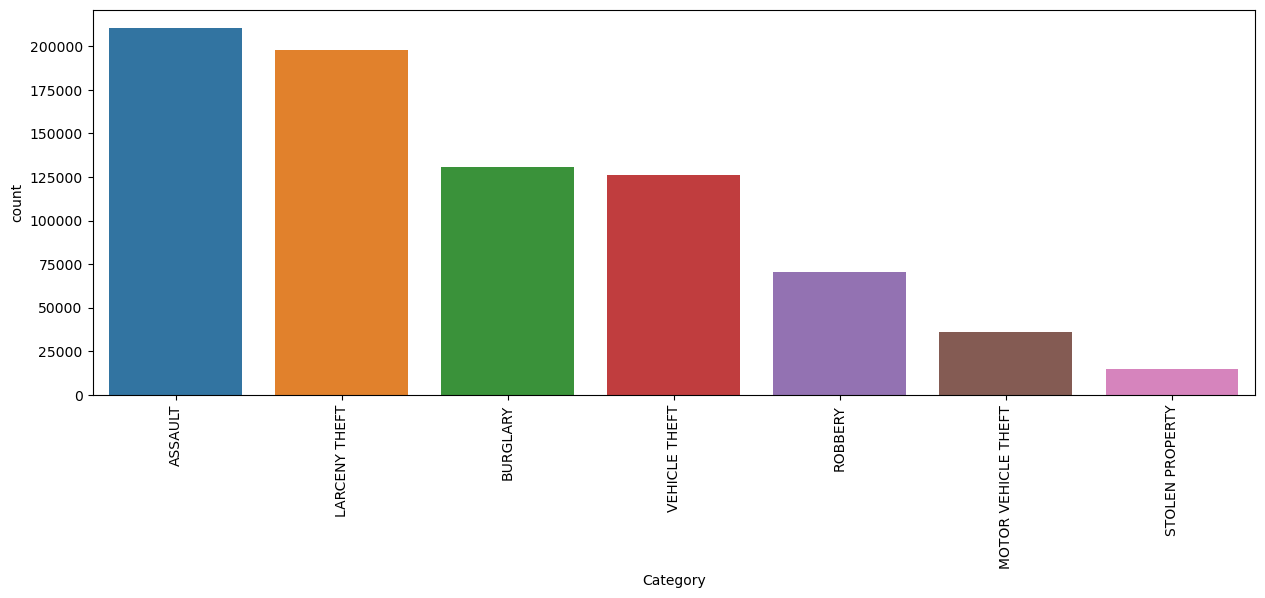

In [64]:
# print the value counts of the categories
plt.figure(figsize=(15,5))
ax = sns.countplot(x = df['Category'], orient='v', order = df['Category'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [66]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(df[['Day_of_Week', 'Part_of_Day']])
one_hot_columns = one_hot_encoder.get_feature_names_out(['Day_of_Week', 'Part_of_Day'])

scaler = StandardScaler()
scaled_columns = ['Year', 'Month', 'Day', 'Time_minutes', 'IsHoliday', 'Latitude', 'Longitude']
scaled_values = scaler.fit_transform(df[scaled_columns])

X = np.hstack((scaled_values, one_hot_encoded))
y = df['Category'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [67]:
# # Select the features for the model
# X = df[['Latitude', 'Longitude', 'Hour']]

# # Use the original crime category labels as the target variable
# y = df['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

In [70]:
# Fit the model to the training data
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# # Get the predicted probabilities for each class
# y_prob = rfc.predict_proba(X_test)

# # Calculate the predicted class using the probabilities
# y_pred = np.argmax(y_prob, axis=1)

In [ ]:
# y_pred_str = y_pred.astype(str)

In [71]:
y_pred = rfc.predict(X_test)

In [73]:
print(y_test.shape)
print(y_pred.shape)

(157417,)
(157417,)


In [72]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.63      0.58     42068
           1       0.47      0.30      0.37     26086
           2       0.66      0.92      0.77     39801
           3       0.36      0.11      0.17      7303
           4       0.30      0.10      0.15     14017
           5       0.10      0.04      0.06      3052
           6       0.57      0.63      0.60     25090

    accuracy                           0.57    157417
   macro avg       0.43      0.39      0.38    157417
weighted avg       0.52      0.57      0.53    157417

